In [278]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.io import imread
%matplotlib inline

In [279]:
def loadImage(path):
    img = imread(path)
    return img

img = loadImage('./data/banana_slug.tiff')

print(img.dtype) #数据类型
print(img.shape)  #显示尺寸
print(img.max())  #最大像素值
print(img.min())  #最小像素值
print(img.mean()) #像素平均值

#imgUnit16 = img.copy()
img = img.astype(np.float64)
#from skimage.util import img_as_float

uint16
(2856, 4290)
15303
2002
2633.924842314548


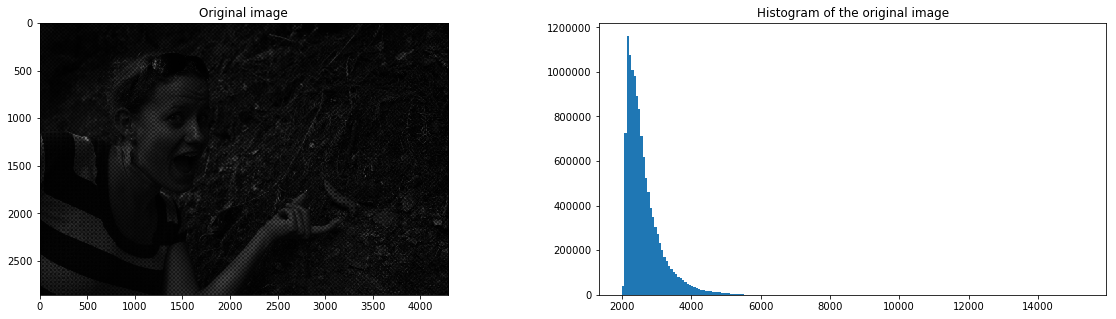

In [280]:
fig=plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title('Original image')
plt.imshow(img,cmap="gray")
plt.subplot(1,2,2)
plt.hist(img.flatten(), bins=200)
plt.title('Histogram of the original image')
plt.show()

我们截取图像中的某一段，例如像素值为2047到15000的部分，而其他的部分如果像素值小于2047则设置为2047，像素值高于15000则设置为15000，并将结果线性缩放到0到1之间

In [281]:
def linearize(img, minValue, maxValue):
    """
    Returns the linearized image, with specified min/max limit value.
    Parameters
    ----------
    img : original image
    minValue: specified min value, pixels lower/equal than minValue will be mapped to 0
    maxValue: specified min value, pixels larger/equal than maxValue will be mapped to 1
    Returns
    -------
    linearized image with pixel value within the range [0, 1]
    """
    ret = (img - minValue)/(maxValue - minValue)
    ret[ret<0] = 0
    ret[ret>1] = 1
    
    return ret
    
imgLin = linearize(img, 2047, 15000)
# imgUnit16Lin = linearize(imgUnit16, 2047, 15000)

# diff = imgLin-imgUnit16Lin
# print(np.where(diff == np.min(diff)))

# print(img[0][3634])
# print(imgUnit16[0][3634])
# print(imgLin[0][3634])
# print(imgUnit16Lin[0][3634])

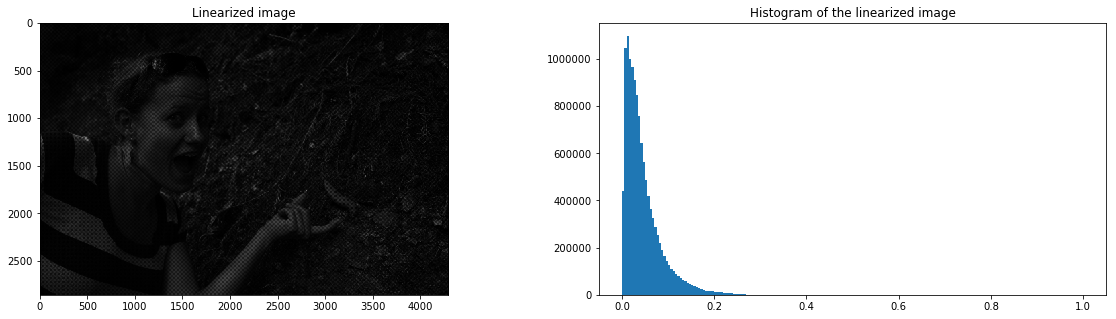

In [282]:
fig=plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title('Linearized image')
plt.imshow(imgLin, cmap="gray")
plt.subplot(1,2,2)
plt.hist(imgLin.flatten(), bins=200)
plt.title('Histogram of the linearized image')
plt.show()

确定正确的Bayer格式,draw得出为RG/GB

得到一个掩模图像，用于得到任意的通道

In [283]:
def masks_CFA_Bayer(shape, pattern='RGGB'):
    """
    Returns the *Bayer* CFA red, green and blue masks for given pattern.
    Parameters
    ----------
    shape : array_like
        Dimensions of the *Bayer* CFA.
    pattern : unicode, optional
        **{'RGGB', 'BGGR', 'GRBG', 'GBRG'}**,
        Arrangement of the colour filters on the pixel array.
    Returns
    -------
    tuple
        *Bayer* CFA red, green and blue masks.
    Examples
    --------
    >>> from pprint import pprint
    >>> shape = (3, 3)
    >>> pprint(masks_CFA_Bayer(shape))
    (array([[ True, False,  True],
           [False, False, False],
           [ True, False,  True]], dtype=bool),
     array([[False,  True, False],
           [ True, False,  True],
           [False,  True, False]], dtype=bool),
     array([[False, False, False],
           [False,  True, False],
           [False, False, False]], dtype=bool))
    >>> pprint(masks_CFA_Bayer(shape, 'BGGR'))
    (array([[False, False, False],
           [False,  True, False],
           [False, False, False]], dtype=bool),
     array([[False,  True, False],
           [ True, False,  True],
           [False,  True, False]], dtype=bool),
     array([[ True, False,  True],
           [False, False, False],
           [ True, False,  True]], dtype=bool))
    """

    pattern = pattern.upper()

    channels = dict((channel, np.zeros(shape)) for channel in 'RGB')
    for channel, (y, x) in zip(pattern, [(0, 0), (0, 1), (1, 0), (1, 1)]):
        channels[channel][y::2, x::2] = 1

    return tuple(channels[c] for c in 'RGB')

cfaMask = masks_CFA_Bayer(imgLin.shape, pattern='RGGB')

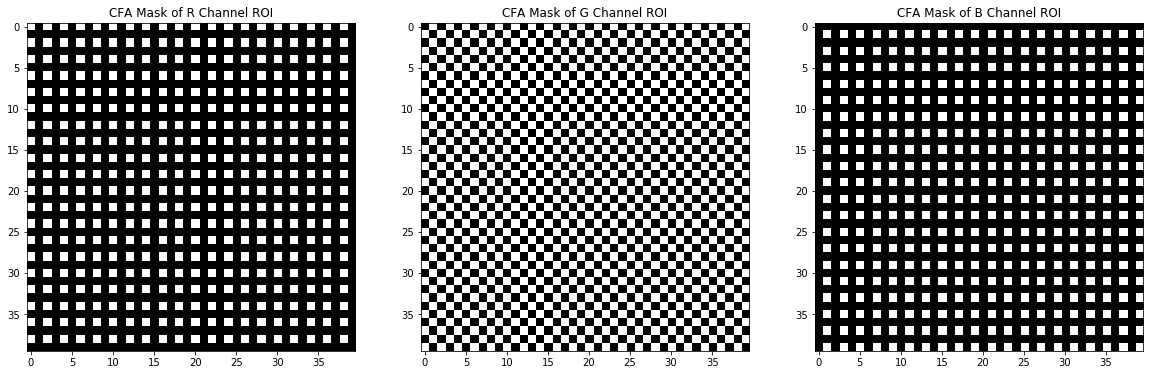

In [284]:
plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(cfaMask[0][0:40,0:40], cmap="gray")
plt.title('CFA Mask of R Channel ROI')
plt.subplot(1,3,2)
plt.imshow(cfaMask[1][0:40,0:40], cmap="gray")
plt.title('CFA Mask of G Channel ROI')
plt.subplot(1,3,3)
plt.imshow(cfaMask[2][0:40,0:40], cmap="gray")
plt.title('CFA Mask of B Channel ROI')
plt.show()

In [285]:
def greyWorldWB(imgIn, cfaMask):
    """
    Implement the grey world white balancing algorithm.
    
    Parameters
    ----------
    imgIn : original image within range [0, 1]
    cfaMask: tuple, *Bayer* CFA red, green and blue masks.

    Returns
    -------
    White balanced image.
    """

    channels = [imgIn * mask for mask in cfaMask]
    channelSums = [im.sum() for im in channels]
    channelCounts = [mask.sum() for mask in cfaMask]
    rgbMeans = [channelSums[i] / channelCounts[i] for i in range(3)]
    
    rIn, gIn, bIn = channels
    rOut = rgbMeans[1] / rgbMeans[0] * rIn
    gOut = gIn
    bOut = rgbMeans[1] / rgbMeans[2] * bIn

    imgOut = rOut * cfaMask[0] + gOut * cfaMask[1] + bOut * cfaMask[2]

    return imgOut

In [286]:
def whiteWorldWB(imgIn, cfaMask):
    """
    Implement the white world white balancing algorithm.
    
    Parameters
    ----------
    imgIn : original image within range [0, 1]
    cfaMask: tuple, *Bayer* CFA red, green and blue masks.

    Returns
    -------
    White balanced image.
    """

    channels = [imgIn * mask for mask in cfaMask]
    rgbMax = [c.max() for c in channels]
    rIn, gIn, bIn = channels
    rOut = rgbMax[1] / rgbMax[0] * rIn
    gOut = gIn
    bOut = rgbMax[1] / rgbMax[2] * bIn

    imgOut = rOut * cfaMask[0] + gOut * cfaMask[1] + bOut * cfaMask[2]

    return imgOut

In [287]:
imgWBGrayWorld = greyWorldWB(imgLin, cfaMask)
imgWBWhiteWorld = whiteWorldWB(imgLin, cfaMask)
print("min/max value of imgWBGrayWorld and imgWBWhiteWorld: (%f, %f) (%f, %f)"%(imgWBGrayWorld.min(), imgWBGrayWorld.max(), imgWBWhiteWorld.min(), imgWBWhiteWorld.max()))
print(imgWBGrayWorld.max())

min/max value of imgWBGrayWorld and imgWBWhiteWorld: (0.000000, 1.144043) (0.000000, 1.000000)
1.144042845830471


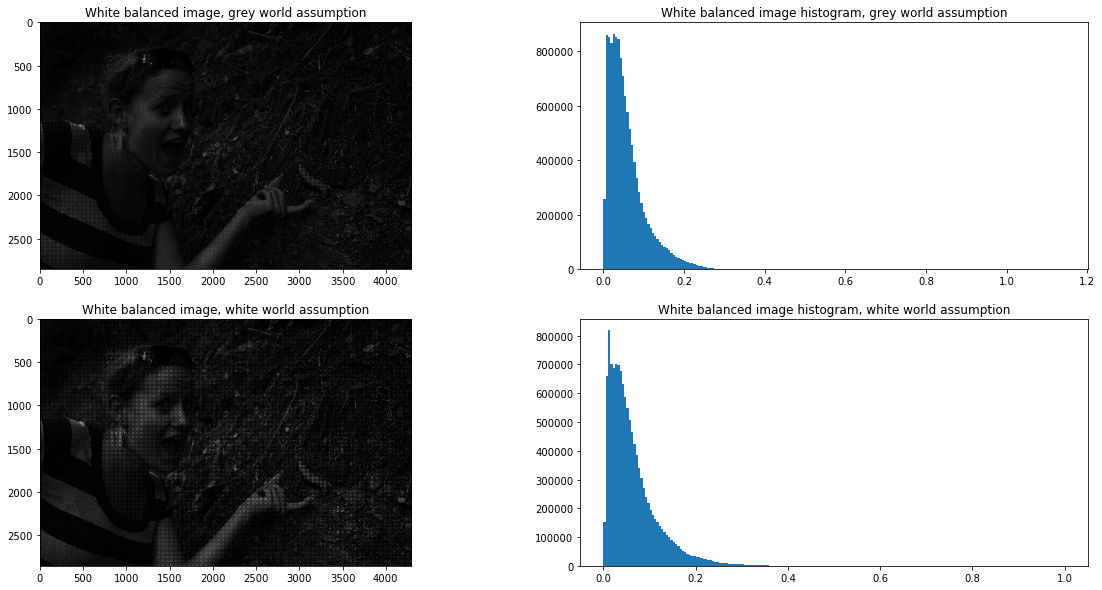

In [288]:
fig=plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.title('White balanced image, grey world assumption')
plt.imshow(imgWBGrayWorld,cmap="gray")
plt.subplot(2,2,2)
plt.hist(imgWBGrayWorld.flatten(), bins=200)
plt.title('White balanced image histogram, grey world assumption')
plt.subplot(2,2,3)
plt.imshow(imgWBWhiteWorld,cmap="gray")
plt.title('White balanced image, white world assumption')
plt.subplot(2,2,4)
plt.hist(imgWBWhiteWorld.flatten(), bins=200)
plt.title('White balanced image histogram, white world assumption')
plt.show()

In [289]:
from scipy.ndimage.filters import convolve
def demosaicing_by_Conv(imgIn, cfaMask):   
    """
    Implement the demosaicing algorithm by convolution.
    
    Parameters
    ----------
    imgIn : original image, might have been white balanced
    cfaMask: tuple, *Bayer* CFA red, green and blue masks.

    Returns        
    -------
    RGB image after demosaicing
    """
    
    H_G = np.asarray(
        [[0, 1, 0],
         [1, 4, 1],
         [0, 1, 0]]) / 4  

    H_RB = np.asarray(
        [[1, 2, 1],
         [2, 4, 2],
         [1, 2, 1]]) / 4  

    rIn, gIn, bIn = [imgIn * mask for mask in cfaMask]
    rOut = convolve(rIn, H_RB)
    gOut = convolve(gIn, H_G)
    bOut = convolve(bIn, H_RB)
    
    ret = np.stack((rOut, gOut, bOut), axis=2)    
    return ret

In [290]:
from scipy.interpolate import RectBivariateSpline, interp2d
def demosaicing_by_interp(imgIn, cfaMask):
    """
    Implement the demosaicing algorithm by interpolation.
    
    Parameters
    ----------
    imgIn : original image, might have been white balanced
    cfaMask: tuple, *Bayer* CFA red, green and blue masks.

    Returns        
    -------
    RGB image after demosaicing
    """
    
    channels = [imgIn * mask for mask in cfaMask]
    H, W = imgIn.shape[0:2]
    #interpolate the R channel
    yPos, xPos=np.meshgrid(np.arange(0,H,2), np.arange(0,W,2), indexing='ij')
    imgVal = imgIn[yPos, xPos]
    interObj = interp2d(np.arange(0,W,2), np.arange(0,H,2), imgVal)
    newR = interObj(np.arange(0,W,1), np.arange(0,H,1))
    
    #interpolate the B channel
    yPos, xPos=np.meshgrid(np.arange(1,H,2), np.arange(1,W,2), indexing='ij')
    imgVal = imgIn[yPos, xPos]
    interObj = interp2d(np.arange(1,W,2), np.arange(1,H,2), imgVal)
    newB = interObj(np.arange(0,W,1), np.arange(0,H,1))
    
    yPos, xPos=np.meshgrid(np.arange(0,H,2), np.arange(1,W,2), indexing='ij')
    imgVal = imgIn[yPos, xPos]
    interObj = interp2d(np.arange(1,W,2), np.arange(0,H,2), imgVal)
    newG1 = interObj(np.arange(0,W,1), np.arange(0,H,1))
    yPos, xPos=np.meshgrid(np.arange(0,H,2), np.arange(1,W,2), indexing='ij')
    imgVal = imgIn[yPos, xPos]
    interObj = interp2d(np.arange(1,W,2), np.arange(0,H,2), imgVal)
    newG2 = interObj(np.arange(0,W,1), np.arange(0,H,1))
    newG = (newG1 + newG2)/2

    ret = np.stack((newR, newG, newB), axis=2)
    return ret

imgGWDMSConv = demosaicing_by_Conv(imgWBGrayWorld, cfaMask)
imgGWDMSInterp = demosaicing_by_interp(imgWBGrayWorld, cfaMask)
imgWWDMSConv = demosaicing_by_Conv(imgWBWhiteWorld, cfaMask)
imgWWDMSInterp = demosaicing_by_interp(imgWBWhiteWorld, cfaMask)

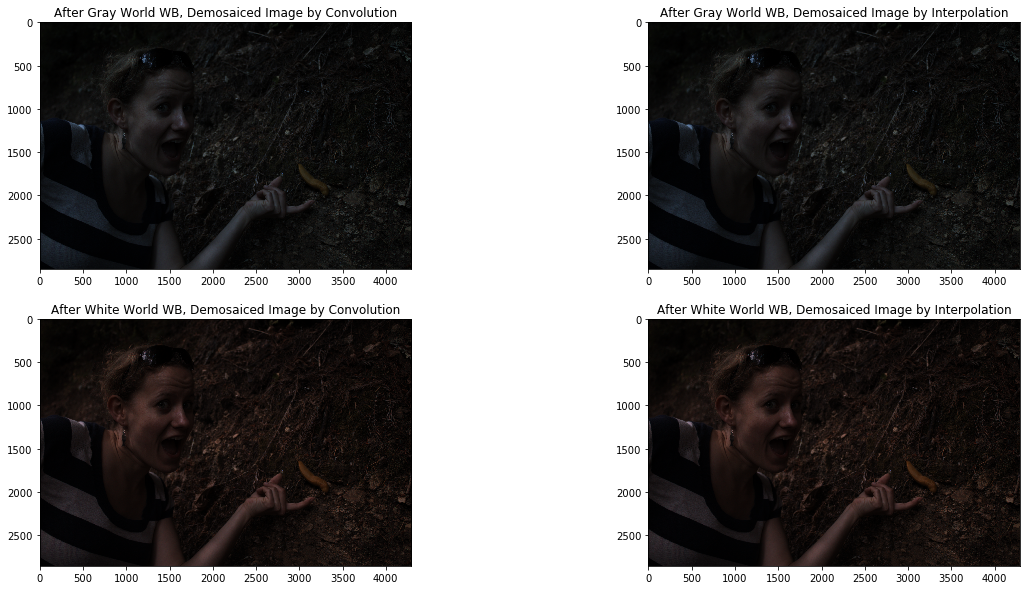

In [291]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.imshow(imgGWDMSConv)
plt.title('After Gray World WB, Demosaiced Image by Convolution')
plt.subplot(2,2,2)
plt.imshow(imgGWDMSInterp)
plt.title('After Gray World WB, Demosaiced Image by Interpolation')
plt.subplot(2,2,3)
plt.imshow(imgWWDMSConv)
plt.title('After White World WB, Demosaiced Image by Convolution')
plt.subplot(2,2,4)
plt.imshow(imgWWDMSInterp)
plt.title('After White World WB, Demosaiced Image by Interpolation')
plt.show()

In [292]:
from skimage.color import rgb2gray, rgb2grey
def scaleImg(imgIn, sv=3):
    """
    Scale the image.
    
    Here we get the max value of gray image converted by imgIn,
    and use this value to get the scale value. 
    
    Parameters
    ----------
    imgIn : original image after demosaicing.
    sv:  a const value to adjust the scale value.
    
    Returns        
    -------
    Scaled image.
    """
    grayImg = rgb2gray(imgIn)
    scale = sv / grayImg.max()
    outImg = imgIn.copy()
    outImg *= scale
    outImg[outImg>1]=1 #Limit the max value to 1 to prevent from over exposure
    return outImg

imgGWScaled = scaleImg(imgGWDMSConv)
imgWWScaled = scaleImg(imgWWDMSConv)

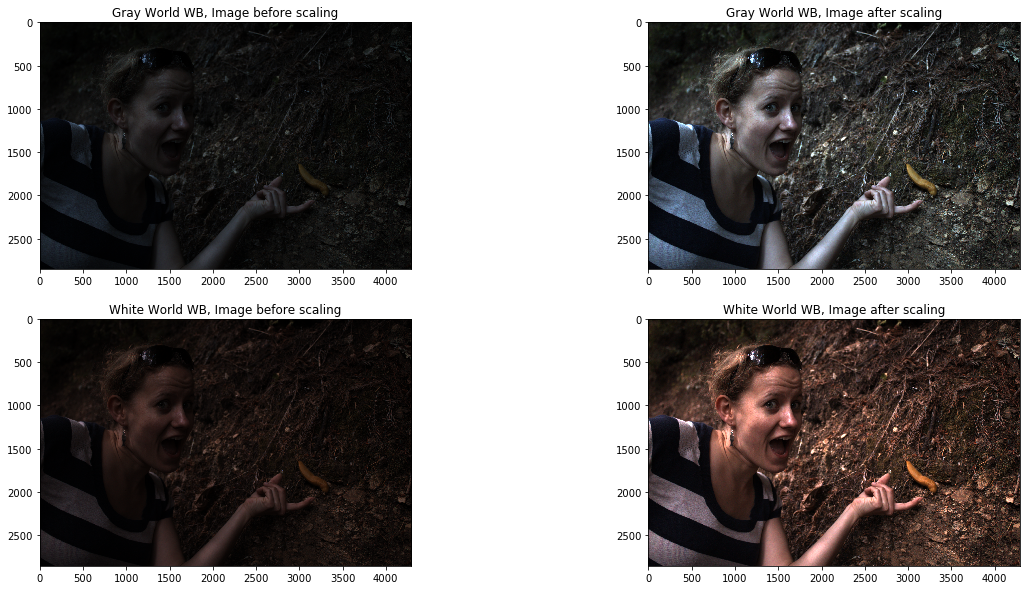

In [293]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.imshow(imgGWDMSConv)
cv2.imwrite("./imgGWDMSConv.jpg",imgGWDMSConv * 255/imgGWDMSConv.max().astype(np.uint8))
plt.title("Gray World WB, Image before scaling")
plt.subplot(2,2,2)
plt.imshow(imgGWScaled)
cv2.imwrite("./imgGWScaled.jpg",imgGWScaled * 255/imgGWScaled.max().astype(np.uint8))
plt.title("Gray World WB, Image after scaling")

plt.subplot(2,2,3)
plt.imshow(imgWWDMSConv)
cv2.imwrite("./imgWWDMSConv.jpg",imgWWDMSConv * 255/imgWWDMSConv.max().astype(np.uint8))
plt.title("White World WB, Image before scaling")
plt.subplot(2,2,4)
plt.imshow(imgWWScaled)
cv2.imwrite("./imgWWScaled.jpg",imgWWScaled * 255/imgWWScaled.max().astype(np.uint8))
plt.title("White World WB, Image after scaling")

plt.show()

#色块问题不在这儿

In [294]:
def gammaCorr(imgIn):
    """
    Scale the image.
    
    Here we get the max value of gray image converted by imgIn,
    and use this value to get the scale value. 
    
    Parameters
    ----------
    imgIn : original image after demosaicing.
    sv:  a const value to adjust the scale value.
    
    Returns        
    -------
    Scaled image.
    """    
    imgOut = imgIn.copy() 
    isDarkPixel = imgIn <= 0.0031308
    
    isBrightPixel = np.logical_not(isDarkPixel)
    imgOut[isDarkPixel] *= 12.92
    imgOut[isBrightPixel] = (1+0.055)*(imgIn[isBrightPixel])**(1/2.4) - 0.055

    return imgOut

outImgGW = gammaCorr(imgGWScaled)
outImgWW = gammaCorr(imgWWScaled)

灰假设在暗处有rgb块，不可稳定复现

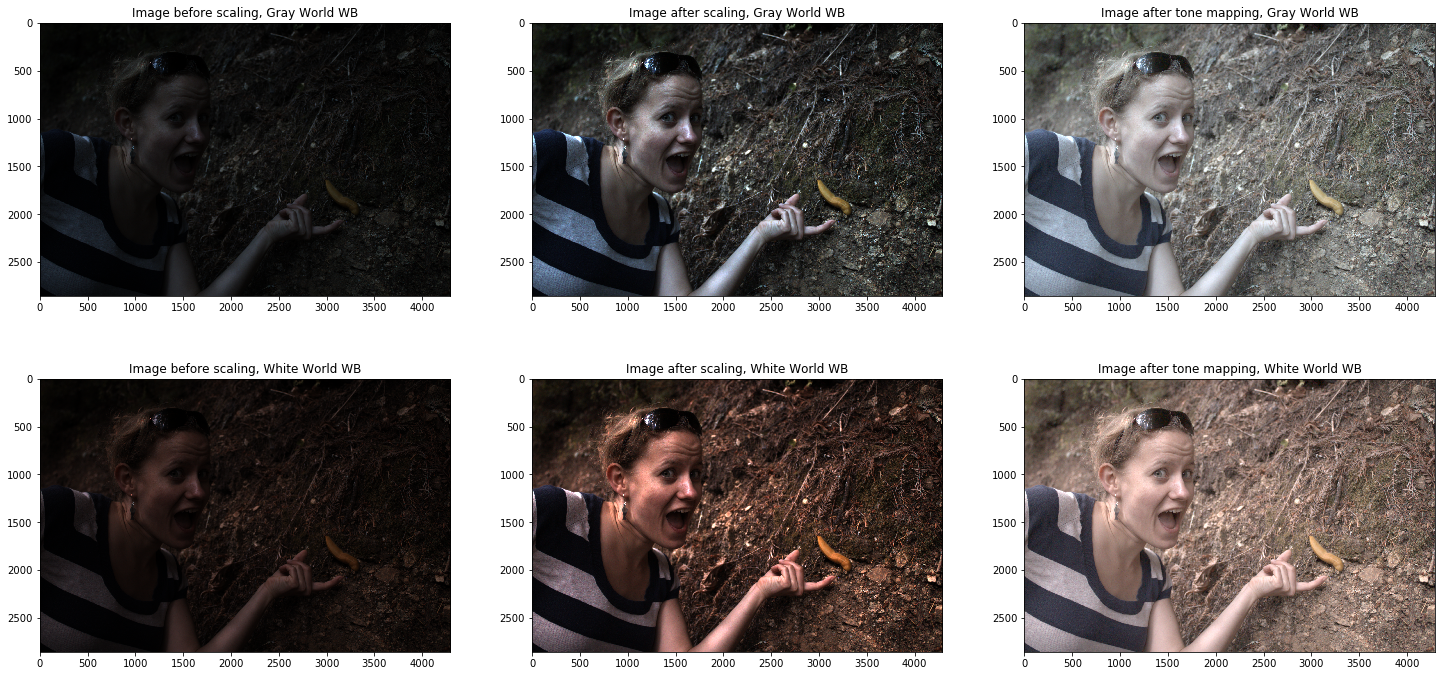

In [295]:
plt.figure(figsize=(25,12))
plt.subplot(2,3,1)
plt.imshow(imgGWDMSInterp)
plt.title("Image before scaling, Gray World WB")
plt.subplot(2,3,2)
plt.imshow(imgGWScaled)
cv2.imwrite("./imgGWScaled.jpg",imgGWScaled * 255)
plt.title("Image after scaling, Gray World WB")
plt.subplot(2,3,3)
plt.imshow(outImgGW)
cv2.imwrite("./outImgGW.jpg",outImgGW * 255)
plt.title("Image after tone mapping, Gray World WB")

plt.subplot(2,3,4)
plt.imshow(imgWWDMSInterp)
plt.title("Image before scaling, White World WB")
plt.subplot(2,3,5)
plt.imshow(imgWWScaled)
plt.title("Image after scaling, White World WB")
plt.subplot(2,3,6)
plt.imshow(outImgWW)
plt.title("Image after tone mapping, White World WB")
plt.show()

In [296]:
import cv2
def saveImg(pureName, img):
    storeImg=(img * 255/img.max()).astype(np.uint8)
    storeImg=cv2.cvtColor(storeImg, cv2.COLOR_RGB2BGR)
    ret=cv2.imwrite("%s.png"%pureName, storeImg)
    ret=cv2.imwrite("%s.jpg"%pureName, storeImg, (cv2.IMWRITE_JPEG_QUALITY,95))
    
saveImg("storeImgGW", outImgGW)
saveImg("storeImgWW", outImgWW)


In [273]:
def raw2rgb(rawImgPath, scale=3, lowLimit=2047, highLimit=15000):
    rawImg = loadImage(rawImgPath)
    imgLinear = linearize(rawImg, lowLimit, highLimit)    
    cfaMask = masks_CFA_Bayer(imgLinear.shape, pattern='RGGB')
    imgWBGrayWorld = greyWorldWB(imgLinear, cfaMask)
    imgGWDMSInterp = demosaicing_by_interp(imgWBGrayWorld, cfaMask)
    imgGWScaled = scaleImg(imgGWDMSInterp, sv=scale)
    outImgGW = gammaCorr(imgGWScaled)
    
    return outImgGW
    
outImgGW = raw2rgb('./data/banana_slug.tiff')    
saveImg("storeImgGW", outImgGW)    

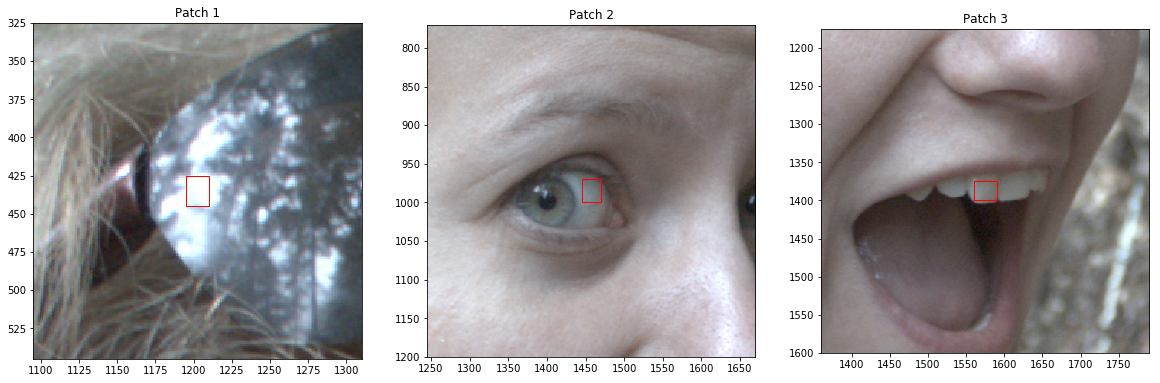

In [297]:
def showROI(img, roiList):    
    imgToShow = outImgGW.copy()
    plt.figure(figsize=(20,10))
    subplotsNum=1
    for roi in roiList:
        ax = plt.subplot(1, len(roiList), subplotsNum)
        top, bottom, left, right, extend = roi
        rect = plt.Rectangle([left, top], right-left, bottom-top, edgecolor='Red', facecolor='None')
        plt.imshow(imgToShow)
        plt.ylim(bottom+extend, top-extend)
        plt.xlim(left-extend, right+extend)
        plt.title("Patch %d"%subplotsNum)
        ax.add_patch(rect)
        subplotsNum+=1
    plt.show()
    
roi1=(425, 445, 1195, 1210, 100)
roi2=(970, 1000, 1445, 1470, 200)
roi3=(1375, 1400, 1560, 1590, 200)
roiList=[roi1, roi2, roi3]
showROI(outImgGW, roiList)    

In [215]:
def greyWorldWBByPatch(imgIn, cfaMask, roi):
    """
    Implement the patch based grey world white balancing algorithm.
    
    Parameters
    ----------
    imgIn : original image within range [0, 1]
    cfaMask: tuple, *Bayer* CFA red, green and blue masks.
    top,bottom,left,right: the image white patch corner position

    Returns
    -------
    White balanced image.
    """
    top, bottom, left, right, extend = roi
    channels = [imgIn * mask for mask in cfaMask]
    
    channelSums = [im[top:bottom, left:right].sum() for im in channels]
    channelCounts = [mask[top:bottom, left:right].sum() for mask in cfaMask]
    
    rgbMeans = [channelSums[i] / channelCounts[i] for i in range(3)]

    rIn, gIn, bIn = channels
    rOut = rgbMeans[1] / rgbMeans[0] * rIn
    gOut = gIn
    bOut = rgbMeans[1] / rgbMeans[2] * bIn

    imgOut = rOut * cfaMask[0] + gOut * cfaMask[1] + bOut * cfaMask[2]

    return imgOut

def raw2rgbPatch(rawImgPath, roi, scale=3, lowLimit=2047, highLimit=15000):
    rawImg = loadImage(rawImgPath)
    imgLinear = linearize(rawImg, lowLimit, highLimit)
    cfaMask = masks_CFA_Bayer(imgLinear.shape, pattern='RGGB')
    imgWBGrayWorld = greyWorldWBByPatch(imgLinear, cfaMask, roi)
    imgGWDMSInterp = demosaicing_by_interp(imgWBGrayWorld, cfaMask)
    imgGWScaled = scaleImg(imgGWDMSInterp, scale)
    outImgGW = gammaCorr(imgGWScaled)
    
    return outImgGW

outImgGWROI1 = raw2rgbPatch('./data/banana_slug.tiff', roi1)
outImgGWROI2 = raw2rgbPatch('./data/banana_slug.tiff', roi2)
outImgGWROI3 = raw2rgbPatch('./data/banana_slug.tiff', roi3)

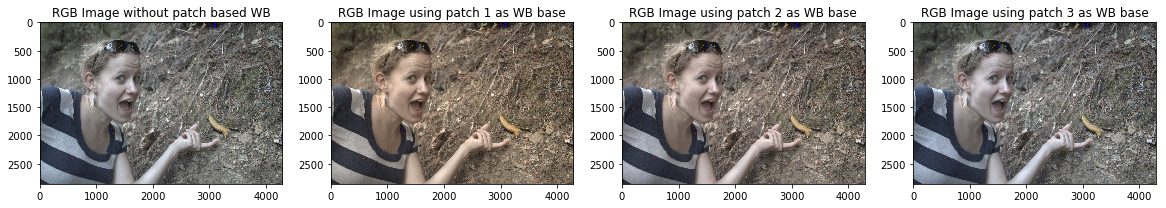

In [224]:
plt.figure(figsize=(20,10))
plt.subplot(1,4,1)
plt.imshow(outImgGW)
plt.title("RGB Image without patch based WB")
plt.subplot(1,4,2)
plt.imshow(outImgGWROI1)
plt.title("RGB Image using patch 1 as WB base")
plt.subplot(1,4,3)
plt.imshow(outImgGWROI2)
plt.title("RGB Image using patch 2 as WB base")
plt.subplot(1,4,4)
plt.imshow(outImgGWROI3)
plt.title("RGB Image using patch 3 as WB base")
plt.show()

saveImg("storeImgGWROI2", outImgGWROI2) 